# 0.0 Imports

In [129]:
import numpy as np
import pandas as pd
import psycopg2 as pg
import sweetviz as sv
import seaborn as sns
import scikitplot as skplt
import warnings
warnings.filterwarnings('ignore')

from IPython.core.display import HTML
from IPython.display import Image
from matplotlib import pyplot as plt
from sklearn import preprocessing as pp
from sklearn import model_selection as ms
from sklearn import ensemble as en
from sklearn import neighbors as nh
from sklearn import linear_model as lm
import xgboost as xgb

## Helper Functions

In [220]:
def pie_chart(data,att,title,legend_title):
    
    def data_detail(pct, allvalues):
        absolute = int(pct/ 100.*np.sum(allvalues['response']))
        return "{:.0f}\n({:.1f}%)".format(absolute, pct)

    wedges, texts, autotexts = plt.pie( data = data,
                                       x = 'response',
                                       autopct = lambda pct: data_detail(pct, data),
                                       textprops = dict(color="w"))
    
    plt.legend( wedges, list(['No', 'Yes']),
              title = legend_title,
              loc="center left",
              bbox_to_anchor = (1, 0, 0.5, 1))
    plt.setp(autotexts, size=10, weight="bold")
    plt.title(title,fontsize = 15);
    
def jupyter_settings():
    %matplotlib inline
    %pylab inline
#     plt.style.use( 'bmh' )
#     plt.rcParams['figure.figsize'] = [25, 12]
#     plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
#     sns.set()
    
jupyter_settings()


def precision_at_k(data, k):
    
    # reset index
    data = data.reset_index(drop=True)

    # create ranking order
    data['ranking'] = data.index + 1

    data['precision_at_k'] = data['response'].cumsum()/data['ranking']

    return data.loc[k,'precision_at_k']

def recall_at_k(data, k):

    # reset index
    data = data.reset_index(drop=True)

    # create ranking order
    data['ranking'] = data.index + 1

    data['recall_at_k'] = data['response'].cumsum()/data['response'].sum()

    return data.loc[k,'recall_at_k']

def cross_validation(data_train,k_fold,model_name, model,verbose):

    validation_size = int(round(data_train.shape[0]*0.2,0))
    
    precision_at_k_list = []
    recall_at_k_list = []

    for k in range(0,k_fold):

        start_validation = validation_size*k
        end_validation   = validation_size*(k+1)
        range_validation = arange(start_validation,end_validation)
        range_data       = arange(0,data_train.shape[0])

        validation = data_train.iloc[ start_validation:end_validation ]
        training = data_train[ ~isin(range_data,range_validation)]

        x_training = training.drop(['id','response'],axis=1)
        y_training = training['response'].copy()

        x_validation = validation.drop(['id','response'],axis=1)
        y_validation = validation['response'].copy()

        # model fit
        m = model.fit(x_training,y_training)

        # model predict
        y_hat = m.predict_proba(x_validation)
        
        data_val = x_validation.copy()
        data_val['response'] = y_validation.copy()

        # Propensity score
        data_val['score'] = y_hat[:,1].tolist()

        # sort clients by propensity score
        data_val = data_val.sort_values('score',ascending=False)
        
        precision_at_k_list.append(precision_at_k(data_val,int(round(data_val.shape[0]*0.2,0))))
        recall_at_k_list.append(recall_at_k(data_val,int(round(data_val.shape[0]*0.2,0))))
        
        if verbose:
            print(f'k_fold: {k}')
            print('Validation Size: {} | {} - {}'.format(validation.shape[0],start_validation,end_validation))
            print('Training Size: {}'.format(training.shape[0]))
            print('Total Size: {}'.format(validation.shape[0] + training.shape[0]))
            print('Total Original Size: {}'.format(data_train.shape[0]))
            print('Precision at K: {}'.format(precision_at_k(data_val,int(round(data_val.shape[0]*0.2,0)))))
            print('Recall at K:    {}'.format(recall_at_k(data_val,int(round(data_val.shape[0]*0.2,0)))))
            print('\n')
            
    return pd.DataFrame(
                        {'Model': model_name,
                         'Precision at K': round(np.mean(precision_at_k_list),4).astype(str) + ' +/- ' + round((np.std(precision_at_k_list)),4).astype(str),
                         'Recall at K':    round(np.mean(recall_at_k_list),4).astype(str) + ' +/- ' + round((np.std(recall_at_k_list)),4).astype(str)},
                          index=[0])

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


# 0.1 Load Dataset

In [131]:
# Credentials

host = 'comunidade-ds-postgres.c50pcakiuwi3.us-east-1.rds.amazonaws.com'
port = 5432
database = 'comunidadedsdb'
username = 'member'
pwd =' cdspa'

# Connection with Database
conn_string = f'host={host} port={port} dbname={database} user={username} password={pwd}'
conn = pg.connect(conn_string)

# SQL Query
query = '''
    select * 
    from pa004.users u LEFT JOIN pa004.vehicle v ON (u.id = v.id)
                       LEFT JOIN pa004.insurance i ON (u.id = i.id)
'''

df = pd.read_sql(query, conn)
conn.close()
df.head()

,id,gender,age,region_code,policy_sales_channel,id,driving_license,vehicle_age,vehicle_damage,id,previously_insured,annual_premium,vintage,response
0,7,Male,23,11.0,152.0,7,1,< 1 Year,Yes,7,0,23367.0,249,0
1,13,Female,41,15.0,14.0,13,1,1-2 Year,No,13,1,31409.0,221,0
2,18,Female,25,35.0,152.0,18,1,< 1 Year,No,18,1,46622.0,299,0
3,31,Female,26,8.0,160.0,31,1,< 1 Year,No,31,0,2630.0,136,0
4,39,Male,45,8.0,124.0,39,1,1-2 Year,Yes,39,0,42297.0,264,0


In [132]:
print('Rows: {}'.format(df.shape[0]))
print('Columns: {}'.format(df.shape[1]))

Rows: 381109
Columns: 14


In [133]:
df_raw = df.loc[:,~df.columns.duplicated()]
df_raw.sample(3)

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response
359478,208784,Male,22,33.0,152.0,1,< 1 Year,No,1,34358.0,251,0
317242,248845,Female,24,46.0,152.0,1,< 1 Year,Yes,0,35511.0,50,0
154067,88158,Male,57,28.0,124.0,1,1-2 Year,No,0,43289.0,92,0


In [134]:
print('Rows: {}'.format(df_raw.shape[0]))
print('Columns: {}'.format(df_raw.shape[1]))

Rows: 381109
Columns: 12


# 1.0 Data Description

In [135]:
df1 = df_raw.copy()

## 1.1 Data Dimension

In [136]:
print('Rows: {}'.format(df1.shape[0]))
print('Columns: {}'.format(df1.shape[1]))

Rows: 381109
Columns: 12


## 1.2 Data Types

In [137]:
df1.dtypes

id                        int64
gender                   object
age                       int64
region_code             float64
policy_sales_channel    float64
driving_license           int64
vehicle_age              object
vehicle_damage           object
previously_insured        int64
annual_premium          float64
vintage                   int64
response                  int64
dtype: object

## 1.3 Change Types

In [138]:
# region_code
df1['region_code'] = df1['region_code'].astype('int64')

# policy_sales_channel 
df1['policy_sales_channel'] = df1['policy_sales_channel'].astype('int64')

In [139]:
df1.dtypes

id                        int64
gender                   object
age                       int64
region_code               int64
policy_sales_channel      int64
driving_license           int64
vehicle_age              object
vehicle_damage           object
previously_insured        int64
annual_premium          float64
vintage                   int64
response                  int64
dtype: object

## 1.4 Check NA

In [140]:
df1.isna().sum()

id                      0
gender                  0
age                     0
region_code             0
policy_sales_channel    0
driving_license         0
vehicle_age             0
vehicle_damage          0
previously_insured      0
annual_premium          0
vintage                 0
response                0
dtype: int64

## 1.5 Data Descriptive

In [141]:
df1.columns

Index(['id', 'gender', 'age', 'region_code', 'policy_sales_channel',
       'driving_license', 'vehicle_age', 'vehicle_damage',
       'previously_insured', 'annual_premium', 'vintage', 'response'],
      dtype='object')

In [142]:
num_attributes = df1[['age','annual_premium','vintage']]
cat_attributes = df1[['gender','driving_license','vehicle_age','vehicle_damage','previously_insured','policy_sales_channel','region_code']]

### 1.5.1 Numerical atributes

In [143]:
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.mean)).T

d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max','range','mean','median','std','skew','kurtosis']

m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,age,20.0,85.0,65.0,38.822584,38.822584,15.511591,0.672539,-0.565655
1,annual_premium,2630.0,540165.0,537535.0,30564.389581,30564.389581,17213.132474,1.766087,34.004569
2,vintage,10.0,299.0,289.0,154.347397,154.347397,83.671194,0.003030,-1.200688


### 1.5.2 Categorical atributes

In [144]:
for i in cat_attributes.columns:
    print(f'{i}: \nNumber of categories: {cat_attributes[i].unique().shape[0]}\nCategories: {sorted(cat_attributes[i].unique())}\n')

gender: 
Number of categories: 2
Categories: ['Female', 'Male']

driving_license: 
Number of categories: 2
Categories: [0, 1]

vehicle_age: 
Number of categories: 3
Categories: ['1-2 Year', '< 1 Year', '> 2 Years']

vehicle_damage: 
Number of categories: 2
Categories: ['No', 'Yes']

previously_insured: 
Number of categories: 2
Categories: [0, 1]

policy_sales_channel: 
Number of categories: 155
Categories: [1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 73, 74, 75, 76, 78, 79, 80, 81, 82, 83, 84, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 143, 144, 14

# 2.0 Feature Engineering

In [145]:
df2 = df1.copy()

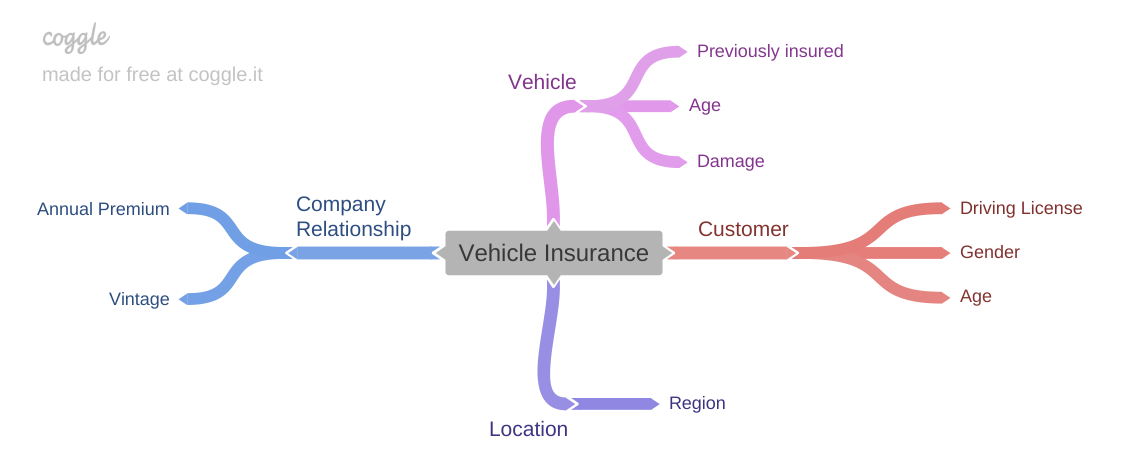

In [146]:
Image('img/Vehicle_Insurance.png')

## 2.1 Hyphotesis Mind Map

### 2.1.1 Customer's Hyphotesis

1. Customers over 40 years old are 50% more interest in vehicle insurance

### 2.1.2 Vehicle's Hyphotesis

1. Customer with a newer vehicle are 30% more interest in adquire the vericle insurance than customer with older cars

### 2.1.3 Company Relationship's Hyphotesis

1. Customer with less than 30 days in relation with the company are 40% more interest in adquire the vehicle insurance

## 2.2 Feature Criation

In [147]:
df2.head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response
0,7,Male,23,11,152,1,< 1 Year,Yes,0,23367.0,249,0
1,13,Female,41,15,14,1,1-2 Year,No,1,31409.0,221,0
2,18,Female,25,35,152,1,< 1 Year,No,1,46622.0,299,0
3,31,Female,26,8,160,1,< 1 Year,No,0,2630.0,136,0
4,39,Male,45,8,124,1,1-2 Year,Yes,0,42297.0,264,0


In [148]:
# vericle_age
df2['vehicle_age'] = df2['vehicle_age'].apply(lambda x: 'bellow_1_year' if x == '< 1 Year' else 
                                                     'between_1_2_year' if x == '1-2 Year' else 
                                                     'over_2_years')

In [149]:
df2.head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response
0,7,Male,23,11,152,1,bellow_1_year,Yes,0,23367.0,249,0
1,13,Female,41,15,14,1,between_1_2_year,No,1,31409.0,221,0
2,18,Female,25,35,152,1,bellow_1_year,No,1,46622.0,299,0
3,31,Female,26,8,160,1,bellow_1_year,No,0,2630.0,136,0
4,39,Male,45,8,124,1,between_1_2_year,Yes,0,42297.0,264,0


# 3.0 Data Filtering

In [150]:
df3 = df2.copy()

# 4.0 Exploratory Data Analysis

In [151]:
df4 = df3.copy()

In [152]:
# report = sv.analyze(df4)
# report.show_html()

## 4.1. Univariate Analysis

### 4.1.1 Numerial Variables

#### 4.1.1.1 Age

- Although people between 20 and 30 years old are not usually interest, people between 40 and 50 years old are offen intereset

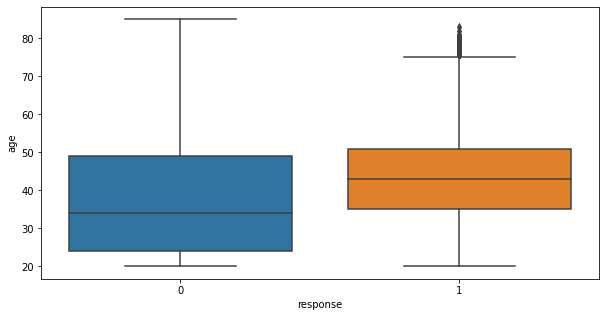

In [153]:
# 'age'
fig = plt.figure(figsize=(10,5))
sns.boxplot(x='response',y='age',data=df4);

##### Not Interesed

##### Interessed

<AxesSubplot:xlabel='age', ylabel='Count'>

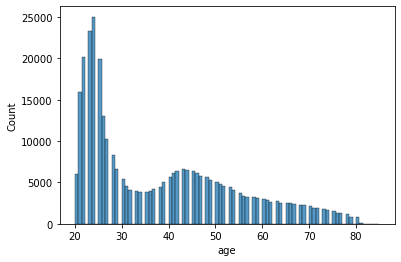

In [154]:
aux00 = df4.loc[df4['response'] == 0, 'age']
sns.histplot(aux00)

<AxesSubplot:xlabel='age', ylabel='Count'>

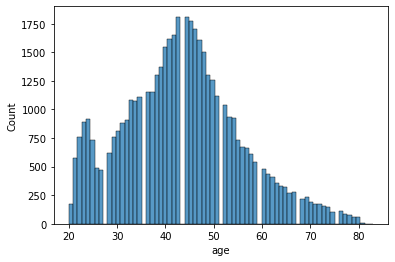

In [155]:
aux00 = df4.loc[df4['response'] == 1, 'age']
sns.histplot(aux00)

#### 4.1.1.2 Annual Premium

- The distribuiton of annual premium are very similuar to interest and not interest people. Only the scale of this distribution are diferent

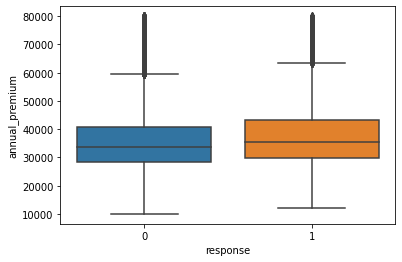

In [156]:
# 'annual_premium'
aux = df4[(df4['annual_premium'] < 80000) & (df4['annual_premium'] > 10000)]
sns.boxplot(x='response',y='annual_premium',data=aux);

##### Interesed

##### Not interessed

<AxesSubplot:xlabel='annual_premium', ylabel='Count'>

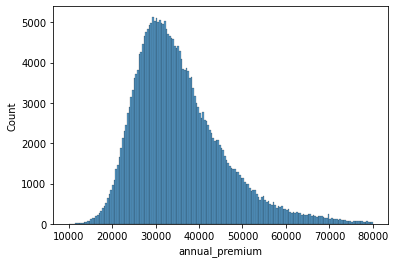

In [157]:
aux00 = aux.loc[aux['response'] == 0, 'annual_premium']
sns.histplot(aux00)

<AxesSubplot:xlabel='annual_premium', ylabel='Count'>

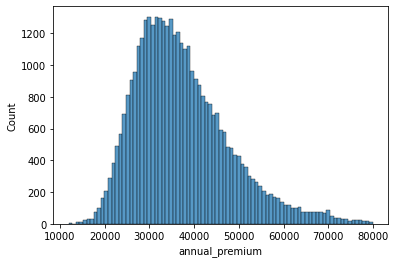

In [158]:
aux00 = aux.loc[aux['response'] == 1, 'annual_premium']
sns.histplot(aux00)

#### 4.1.1.3 Vintage

- The vintage (days that the customer is related with the company) is uniform distribuited

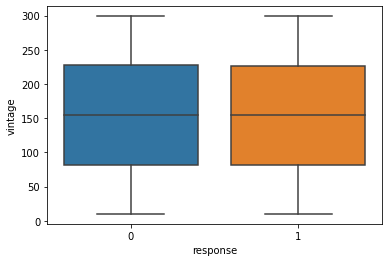

In [159]:
# 'annual_premium'
sns.boxplot(x='response',y='vintage',data=df4);

##### Not intereset

##### Intereset

<AxesSubplot:xlabel='vintage', ylabel='Count'>

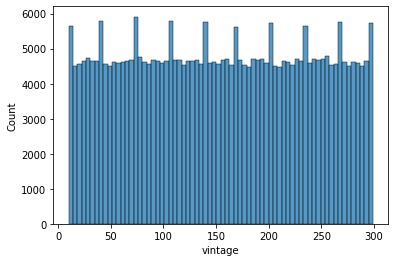

In [160]:
aux00 = df4.loc[df4['response'] == 0, 'vintage']
sns.histplot(aux00)

<AxesSubplot:xlabel='vintage', ylabel='Count'>

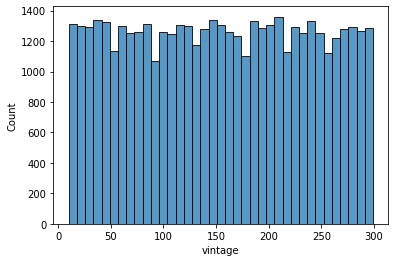

In [161]:
aux00 = df4.loc[df4['response'] == 1, 'vintage']
sns.histplot(aux00)

### 4.1.2 Categorical Variables

#### 4.1.2.1 Gender

- Mens represents 54% of the elevible customer but represents 61% of whole car insurance interest

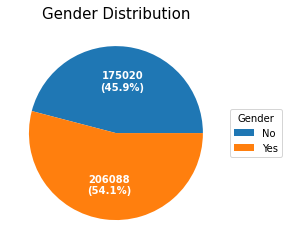

In [162]:
aux2 = pd.DataFrame(df4[['gender','response']].groupby('gender').count()).reset_index()
pie_chart(aux2,'gender',"Gender Distribution",'Gender')

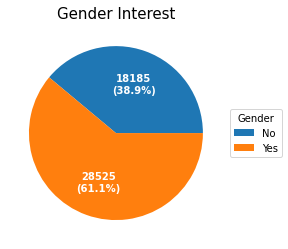

In [163]:
# pie plot
# ax = plt.figure(figsize=(15,6))
aux2 = pd.DataFrame(df4[['gender','response']].groupby('gender').sum()).reset_index()
pie_chart(aux2,'gender',"Gender Interest",'Gender')

#### 4.1.2.2 Driving License

- The majority people has driving license

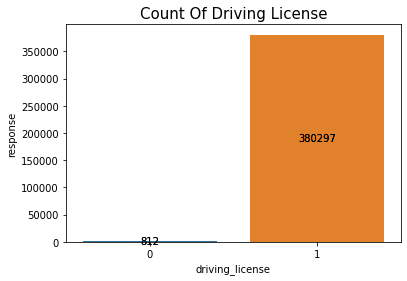

In [164]:
aux1 = df4[['driving_license','response']].groupby('driving_license').count().reset_index()
g = sns.barplot(x = 'driving_license', y = 'response', data = aux1)
g.set_title('Count Of Driving License',fontsize=15)

# incluindo labels nas barras
for i in g.containers:
    g.bar_label(i, color='black', label_type= 'center',fontsize='medium',fmt='%.0f')
    g.bar_label(i, color='black', label_type= 'center',fontsize='medium',fmt='%.0f',)

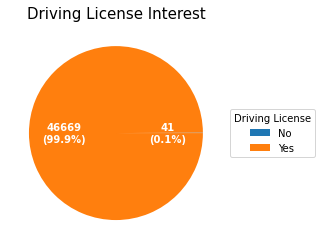

In [165]:
# pie plot
aux1 = pd.DataFrame(df4[['driving_license','response']].groupby('driving_license').sum()).reset_index()
pie_chart(aux1,'driving_license',"Driving License Interest",'Driving License')

#### 4.1.2.3 Region Code

- No region code has a significant majority of interest

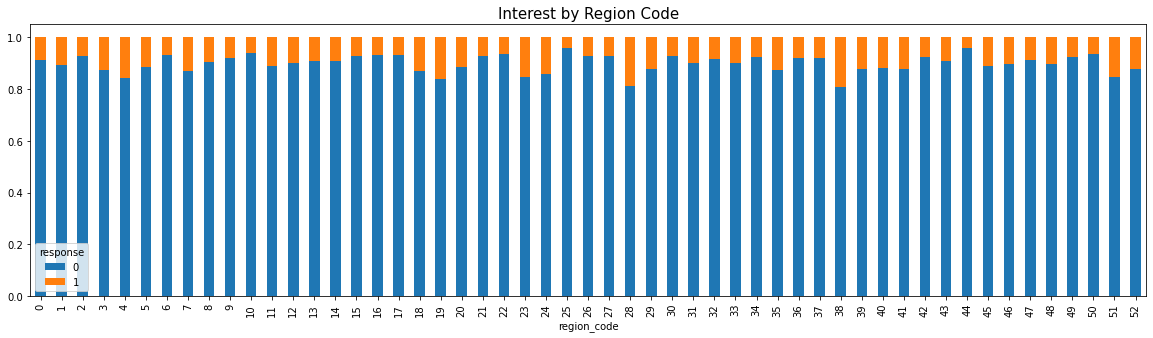

In [166]:
df_grouped = df4[["region_code", "response"]].groupby('region_code').value_counts(normalize=True).unstack('response')
df_grouped.plot.bar(stacked=True,figsize=(20,5));
plt.title('Interest by Region Code',fontsize=15);

#### 4.1.2.4 Previously Insured

- Although the similar number of people previously and not previously car insured, the people that haven't previoulsly insurance are the most interested

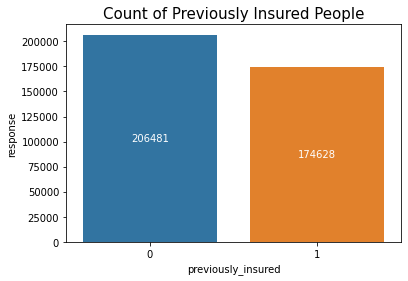

In [167]:
aux1 = df4[['previously_insured','response']].groupby('previously_insured').count().reset_index()
g = sns.barplot(x = 'previously_insured', y = 'response', data = aux1)
g.set_title('Count of Previously Insured People',fontsize=15)

# incluindo labels nas barras
for i in g.containers:
    g.bar_label(i, color='white', label_type= 'center',fontsize='medium',fmt='%.0f')

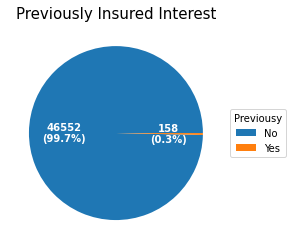

In [168]:
aux1 = pd.DataFrame(df4[['previously_insured','response']].groupby('previously_insured').sum()).reset_index()
pie_chart(aux1,'previously_insured',"Previously Insured Interest",'Previousy')

#### 4.1.2.5 Vericle Age

- THe majority of people has cars bellow 2 years old, but the more interested people has cars over 2 years

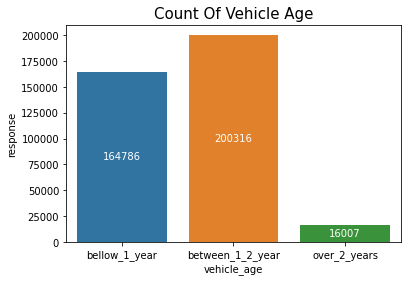

In [169]:
aux1 = df4[["vehicle_age", "response"]].groupby('vehicle_age').count().reset_index()
g = sns.barplot(x = 'vehicle_age', y = 'response', data = aux1)
g.set_title('Count Of Vehicle Age',fontsize=15)

# incluindo labels nas barras
for i in g.containers:
    g.bar_label(i, color='white', label_type= 'center',fontsize='medium',fmt='%.0f')

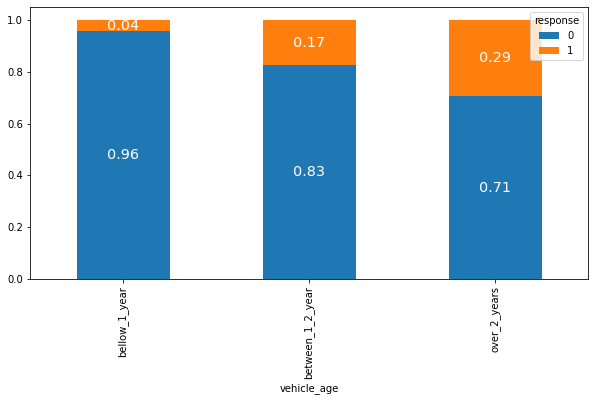

In [170]:
# 'vehicle_age'
df_grouped = df4[["vehicle_age", "response"]].groupby('vehicle_age').value_counts(normalize=True).unstack('response')
g = df_grouped.plot.bar(stacked=True,figsize=(10,5));

for i in g.containers:
    g.bar_label(i, color='white', label_type= 'center',fontsize='x-large',fmt='%.2f')

#### 4.1.2.6 Policy Sales Channel

- Although the quantity diference of sales channel, no channel has the majority of the interest people

In [171]:
# policy_sales_channel
aux0 = df4[['policy_sales_channel','response']].groupby('policy_sales_channel').sum().reset_index()
aux1 = aux0[aux0['response'] > 40.0]### 4.1.6 Previously Insured

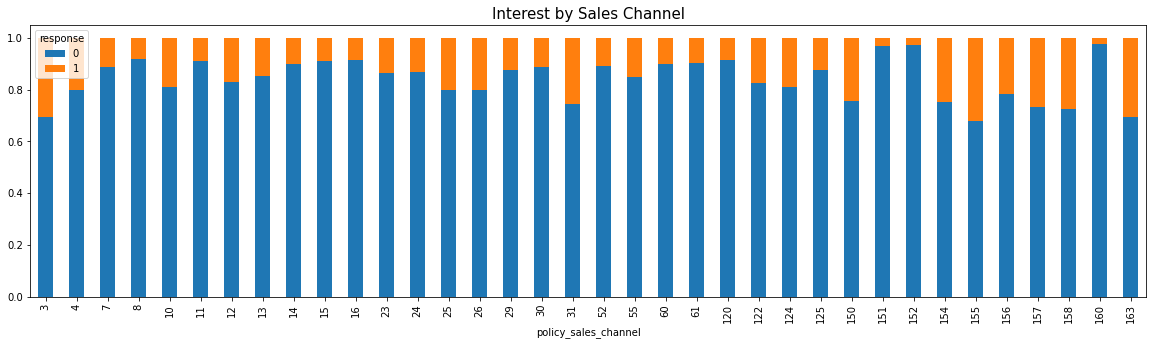

In [172]:
aux = df4[["policy_sales_channel", "response"]].groupby('policy_sales_channel').sum().reset_index()
aux = aux[aux['response'] > 40]

# 'policy_sales_channel'
aux2 = df4[df4['policy_sales_channel'].isin(aux['policy_sales_channel'])]
df_grouped = aux2[["policy_sales_channel", "response"]].groupby('policy_sales_channel').value_counts(normalize=True).unstack('response')
df_grouped.plot.bar(stacked=True,figsize=(20,5));
plt.title('Interest by Sales Channel',fontsize=15);

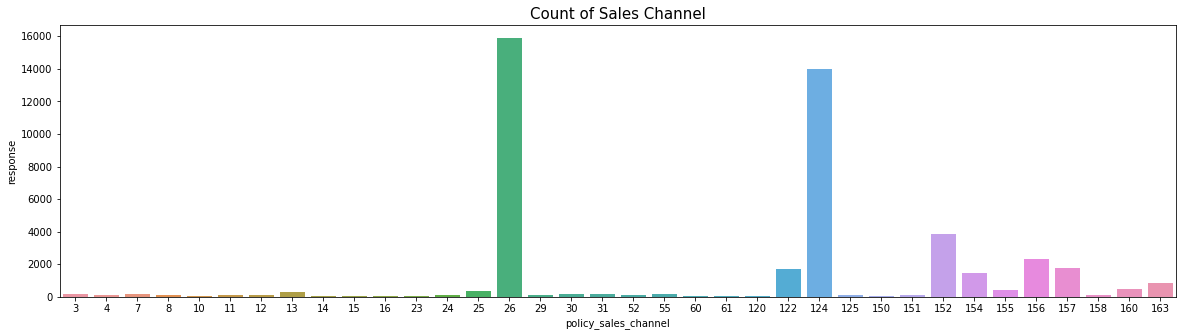

In [173]:
fig = plt.figure(figsize=(20,5))
aux = df4[["policy_sales_channel", "response"]].groupby('policy_sales_channel').sum().reset_index()
aux = aux[aux['response'] > 40]

sns.barplot(data=aux,x='policy_sales_channel',y='response');
plt.title('Count of Sales Channel',fontsize=15);

#### 4.1.2.7 Vehicle Damage

- Although tha simular number of damage and not damage vehicles, people that are more interest has a vehicle damage in the past

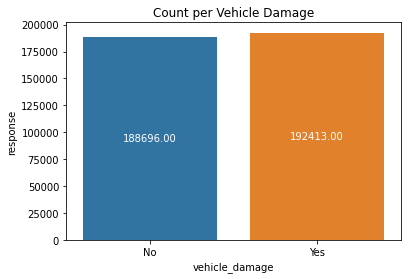

In [174]:
# 'vehicle_damage'
aux1 = df4[['vehicle_damage','response']].groupby('vehicle_damage').count().reset_index()
g = sns.barplot(x = 'vehicle_damage', y = 'response', data = aux1)
g.set_title('Count per Vehicle Damage')

# incluindo labels nas barras
for i in g.containers:
    g.bar_label(i, color='white', label_type= 'center',fontsize='medium',fmt='%.2f')

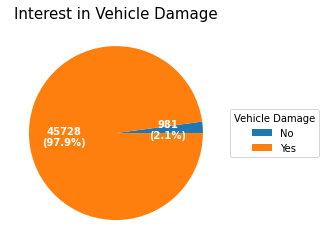

In [175]:
# pie plot
aux1 = pd.DataFrame(df4[['vehicle_damage','response']].groupby('vehicle_damage').sum()).reset_index()
pie_chart(aux1,'vehicle_damage',"Interest in Vehicle Damage",'Vehicle Damage')

## 4.2. Bivariate Analysis

### H1. Customers over 40 years old are 50% more interest in vehicle insurance

- **False**, customer over 40 years old are 48% more interest in vehicle insurance than others

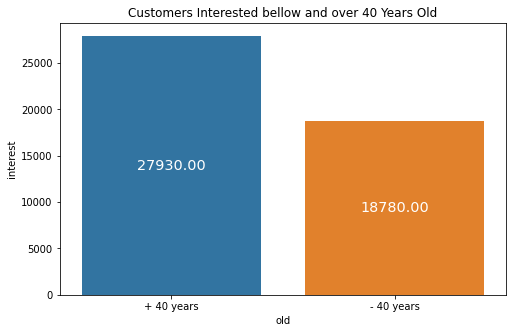

In [176]:
aux = df4[['age','response']].copy()
aux['old'] = df4['age'].apply(lambda x: '+ 40 years' if x > 40 else '- 40 years')
aux = aux[['old','response']].groupby('old').sum().reset_index().rename(columns={'response':'interest'})

fig = plt.figure(figsize=(8,5))
g = sns.barplot(x='old', y='interest', data=aux)
plt.title('Customers Interested bellow and over 40 Years Old')

for i in g.containers:
    g.bar_label(i, color='white', label_type= 'center',fontsize='x-large',fmt='%.2f')

In [177]:
aux['perc'] = (round(aux['interest']/aux['interest'].sum()*100,2)).astype(str) + '%'
aux['diff'] = aux['interest'].rolling(window=2).apply(lambda x: round((x.iloc[0])*100/x.iloc[1]-100,2))
aux

,old,interest,perc,diff
0,+ 40 years,27930,59.79%,NaN
1,- 40 years,18780,40.21%,48.72


### H2. Customer with a newer vehicle are 30% more interest in adquire the vericle insurance than customer with older cars

- **False**, customer with newer vehicle are 81% less interest in adquive the insurance

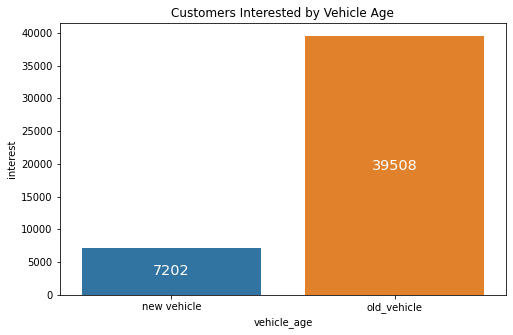

In [178]:
aux = df4[['vehicle_age','response']].copy()
aux['vehicle_age'] = aux['vehicle_age'].apply(lambda x: 'new vehicle' if x == 'bellow_1_year' else 'old_vehicle')
aux = aux.groupby('vehicle_age').sum().reset_index().rename(columns={'response':'interest'})

fig = plt.figure(figsize=(8,5))
g = sns.barplot(x='vehicle_age', y='interest', data=aux)
plt.title('Customers Interested by Vehicle Age')

for i in g.containers:
    g.bar_label(i, color='white', label_type= 'center',fontsize='x-large',fmt='%.0f')

In [179]:
aux['perc'] = (round(aux['interest']/aux['interest'].sum()*100,2)).astype(str) + '%'
aux['diff'] = aux['interest'].rolling(window=2).apply(lambda x: round((x.iloc[0])*100/x.iloc[1]-100,2))
aux

,vehicle_age,interest,perc,diff
0,new vehicle,7202,15.42%,NaN
1,old_vehicle,39508,84.58%,-81.77


### H3. Customer with more days in relation with the company are more interest in adquire the vehicle insurance

- **False**, as longer as the customer relationship with the company are, the lower is the interest

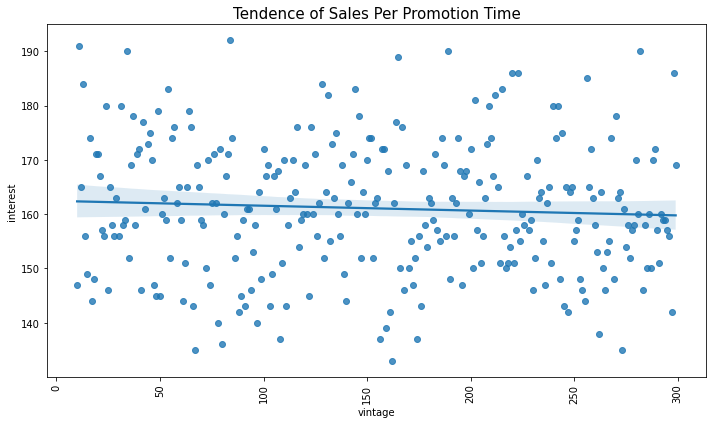

In [180]:
aux = df4[['vintage','response']].copy()
aux = aux.groupby('vintage').sum().reset_index().rename(columns={'response':'interest'})

fig = plt.figure(figsize=(10,6))
sns.regplot(x='vintage', y='interest',data=aux);
plt.xticks(rotation=90);
plt.title('Tendence of Sales Per Promotion Time',fontsize=15)
plt.tight_layout()

# 5.0 Data Preparation

In [181]:
df5 = df4.copy()

## 5.1 Split Train and Validation Datasets

In [182]:
X = df4.drop(['response'],axis=1)
y = df4['response'].copy()

x_train, x_validation, y_train, y_validation = ms.train_test_split(X, y, test_size=0.2)

data_train = pd.concat([x_train, y_train], axis=1)

In [183]:
data_train.head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response
178569,283845,Female,23,15,152,1,bellow_1_year,No,1,52340.0,279,0
376098,341276,Male,22,28,152,1,bellow_1_year,Yes,0,83187.0,136,1
100371,38525,Female,22,8,152,1,bellow_1_year,No,1,49364.0,30,0
294556,67284,Male,48,28,26,1,between_1_2_year,Yes,0,46986.0,286,1
44363,353900,Male,56,8,163,1,between_1_2_year,Yes,0,35126.0,59,0


## 5.2 Standardization

In [184]:
ss = pp.StandardScaler()

## annual_premium
data_train['annual_premium'] = ss.fit_transform(data_train[['annual_premium']].values)

## 5.3 Rescaling

In [185]:
mms_age = pp.MinMaxScaler()
mms_vintage = pp.MinMaxScaler()

## age
data_train['age'] = mms_age.fit_transform( data_train[['age']].values )

## vintage
data_train['vintage'] = mms_age.fit_transform( data_train[['vintage']].values )

## 5.4 Encoder

### 5.4.1 One Hot Enconding

In [186]:
## vehicle_age
data_train = pd.get_dummies(data_train, prefix='vehicle_age',columns=['vehicle_age'])

### 5.4.2 Target Enconding

In [187]:
# gender 
target_encode_gender = data_train.groupby('gender')['response'].mean()
data_train.loc[:,'gender'] = data_train['gender'].map(target_encode_gender)

# region_code 
target_encode_region_code = data_train.groupby('region_code')['response'].mean()
data_train.loc[:,'region_code'] = data_train['region_code'].map(target_encode_region_code)

# vehicle damage
target_encode_vehicle_damage = data_train.groupby('vehicle_damage')['response'].mean()
data_train.loc[:,'vehicle_damage'] = data_train['vehicle_damage'].map(target_encode_vehicle_damage)

### 5.4.3 Frequency Enconding

In [188]:
## policy_sales_channel 
fe_policy_sales_channel = data_train.groupby('policy_sales_channel').size()/len(data_train)
data_train.loc[:,'policy_sales_channel'] = data_train['policy_sales_channel'].map(fe_policy_sales_channel)

In [189]:
data_train.head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_damage,previously_insured,annual_premium,vintage,response,vehicle_age_bellow_1_year,vehicle_age_between_1_2_year,vehicle_age_over_2_years
178569,283845,0.104208,0.046154,0.070793,0.353892,1,0.005375,1,1.266887,0.930796,0,1,0,0
376098,341276,0.138361,0.030769,0.187540,0.353892,1,0.237608,0,3.061015,0.435986,1,1,0,0
100371,38525,0.104208,0.030769,0.096905,0.353892,1,0.005375,1,1.093797,0.069204,0,1,0,0
294556,67284,0.138361,0.430769,0.187540,0.208412,1,0.237608,0,0.955487,0.955017,1,0,1,0
44363,353900,0.138361,0.553846,0.096905,0.007652,1,0.237608,0,0.265684,0.169550,0,0,1,0


## 5.5 Validation Preparation

In [190]:
x_validation.head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage
312970,214859,Female,49,28,30,1,between_1_2_year,Yes,0,35419.0,137
73992,209012,Male,72,36,124,1,between_1_2_year,Yes,0,29273.0,222
146001,24614,Male,31,50,152,1,bellow_1_year,No,0,30070.0,135
77818,239517,Male,26,6,152,1,bellow_1_year,No,1,21503.0,170
289687,28053,Male,22,30,152,1,bellow_1_year,No,1,37301.0,207


In [191]:
# ==============================
# ======= Standarization
# annual_premium
x_validation.loc[:,'annual_premium'] = ss.fit_transform(x_validation[['annual_premium']].values)

# ==============================
# ======= Rescaling
# age
x_validation.loc[:,'age'] = mms_age.fit_transform(x_validation[['age']].values)
# vintage
x_validation.loc[:, 'vintage'] = mms_vintage.fit_transform(x_validation[['vintage']].values)

# ==============================
# ====== One Hot Enconding 
# vehicle_age
x_validation = pd.get_dummies(x_validation, prefix = 'vehicle_age',columns=['vehicle_age'])

# ==============================
# ====== Target Enconding 
# gender
x_validation.loc[:,'gender'] = x_validation.loc[:,'gender'].map(target_encode_gender)
# region_code
x_validation.loc[:,'region_code'] = x_validation.loc[:,'region_code'].map(target_encode_region_code)
# vehicle_damage
x_validation.loc[:,'vehicle_damage'] = x_validation.loc[:,'vehicle_damage'].map(target_encode_vehicle_damage)

# ==============================
# ====== Frequency Enconding 
# policy_sales_channel
x_validation.loc[:,'policy_sales_channel'] = x_validation['policy_sales_channel'].map(fe_policy_sales_channel)

# fillna
x_validation = x_validation.fillna(0)

In [192]:
x_validation.head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_damage,previously_insured,annual_premium,vintage,vehicle_age_bellow_1_year,vehicle_age_between_1_2_year,vehicle_age_over_2_years
312970,214859,0.104208,0.446154,0.187540,0.003654,1,0.237608,0,0.279264,0.439446,0,1,0
73992,209012,0.138361,0.800000,0.080641,0.194065,1,0.237608,0,-0.076158,0.733564,0,1,0
146001,24614,0.138361,0.169231,0.063442,0.353892,1,0.005375,0,-0.030067,0.432526,1,0,0
77818,239517,0.138361,0.092308,0.070677,0.353892,1,0.005375,1,-0.525495,0.553633,1,0,0
289687,28053,0.138361,0.030769,0.074025,0.353892,1,0.005375,1,0.388100,0.681661,1,0,0


# 6.0 Feature Selection

## 6.1 Feature Importance

In [193]:
# model definition
forest = en.ExtraTreesClassifier(n_estimators=250, random_state=0, n_jobs=-1)

x_train_n = data_train.drop(['id', 'response'], axis=1)
y_train_n = y_train.values
forest.fit(x_train_n, y_train_n)

importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print('Feature ranking')
df = pd.DataFrame()
for i, j in zip(x_train_n.columns, forest.feature_importances_):
    aux = pd.DataFrame({'feature': i, 'importance': j},index=[0])
    df= pd.concat([df, aux], axis=0)

df = df.sort_values('importance',ascending=False)

Feature ranking


In [194]:
df

,feature,importance
0,vintage,0.273901
0,annual_premium,0.244486
0,age,0.164764
0,region_code,0.105309
0,vehicle_damage,0.067096
0,policy_sales_channel,0.059464
0,previously_insured,0.056483
0,vehicle_age_bellow_1_year,0.014630
0,vehicle_age_between_1_2_year,0.006413
0,gender,0.004876


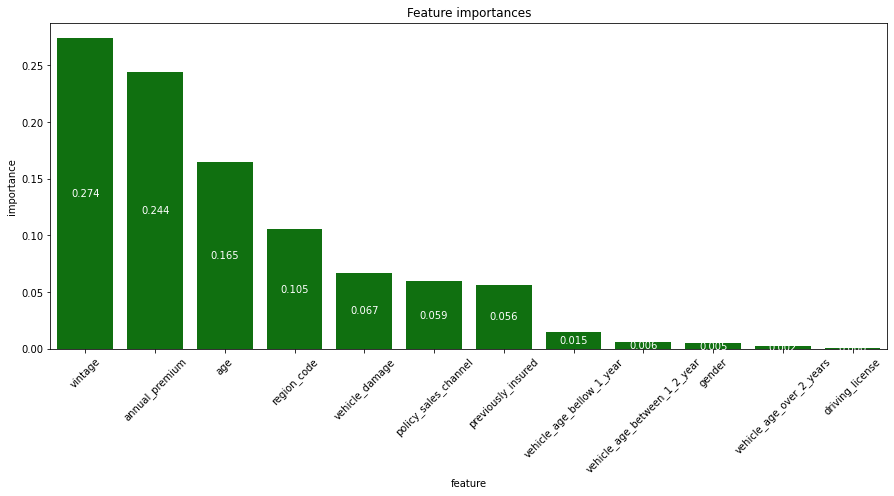

In [195]:
# plot the impurity-based feature importance of the forest

plt.figure(figsize=(15,6))
plt.title('Feature importances')
g = sns.barplot(x='feature',y='importance',data=df,color='green')
plt.xticks(rotation=45)

for i in g.containers:
    g.bar_label(i, color='white', label_type= 'center',fontsize='medium',fmt='%.3f')

# 7.0 Machine Learning

In [196]:
cols_selected = ['vintage',
                'annual_premium',
                'age',
                'region_code',
                'vehicle_damage',
                'policy_sales_channel',
                'previously_insured']

x_train = data_train[cols_selected]
x_val = x_validation[cols_selected]

## 7.1 KNN

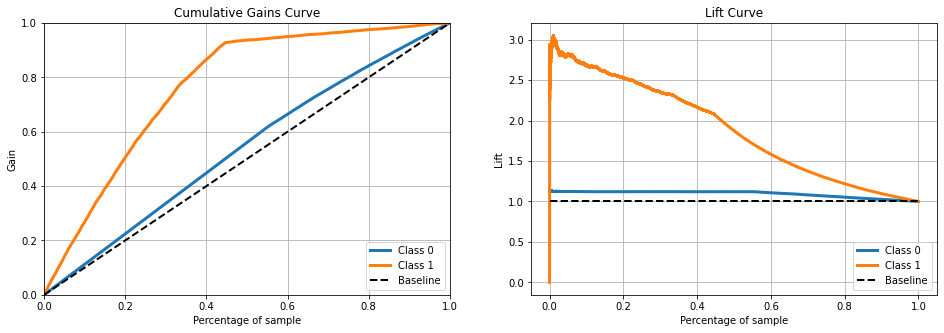

In [221]:
# model definition
knn_model = nh.KNeighborsClassifier(n_neighbors=10)

# model training
knn_model.fit(x_train, y_train)

# model prediction
yhat_knn = knn_model.predict_proba(x_val)

# plot
fig, ax = plt.subplots(1,2,figsize=(16,5))

# Accumulative Gain 
skplt.metrics.plot_cumulative_gain(y_validation,yhat_knn,ax=ax[0])
skplt.metrics.plot_lift_curve(y_validation,yhat_knn,ax=ax[1]);

### Cross Validation

In [230]:
knn_cross = cross_validation(data_train,5,'KNN',knn_model,verbose=False)
knn_cross

,Model,Precision at K,Recall at K
0,KNN,0.3116 +/- 0.0034,0.508 +/- 0.0028


## 7.2 Logistic Regressor

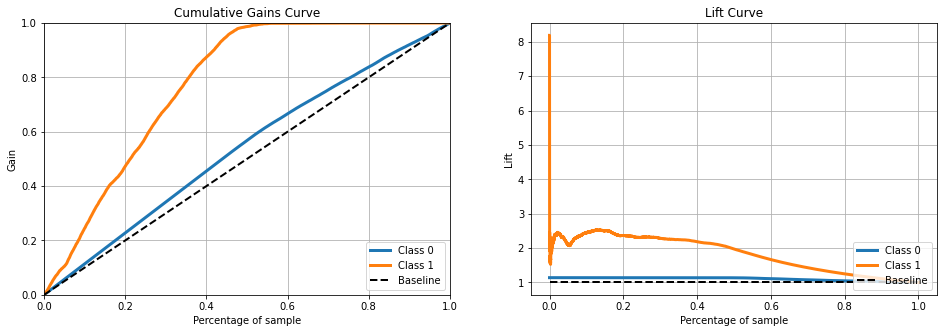

In [224]:
# model definition
lr_model = lm.LogisticRegression(random_state=42)

# model training 
lr_model.fit(x_train, y_train)

# model prediction
yhat_lr = lr_model.predict_proba(x_val)

# plot
fig, ax = plt.subplots(1,2,figsize=(16,5))

# Accumulative Gain 
skplt.metrics.plot_cumulative_gain(y_validation,yhat_lr,ax=ax[0]);
skplt.metrics.plot_lift_curve(y_validation,yhat_lr,ax=ax[1]);

### Cross Validation

In [225]:
lr_cross = cross_validation(data_train,5,'Logistic Regression',lr_model,verbose=False)
lr_cross

,Model,Precision at K,Recall at K
0,Logistic Regression,0.3305 +/- 0.0046,0.5388 +/- 0.0072


## 7.3 Extra Trees

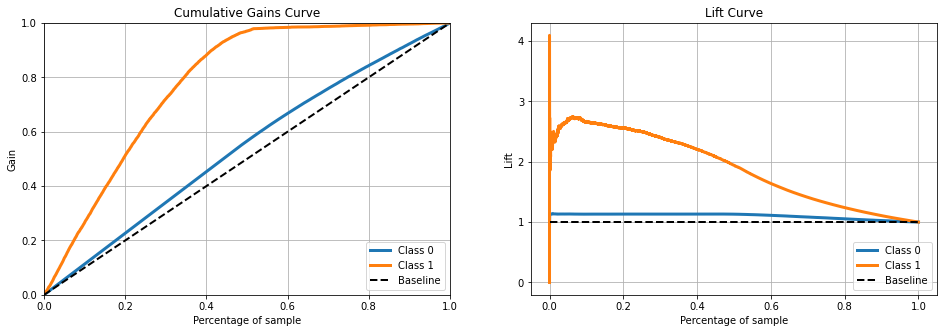

In [201]:
# model definition
et = en.ExtraTreesClassifier(n_estimators = 100, n_jobs=-1, random_state=42)

# model fit
et.fit(x_train, y_train)

# model predict
yhat_et = et.predict_proba(x_val)

# plot
fig, ax = plt.subplots(1,2,figsize=(16,5))

# Accumulative Gain 
skplt.metrics.plot_cumulative_gain(y_validation,yhat_et,ax=ax[0])
skplt.metrics.plot_lift_curve(y_validation,yhat_et,ax=ax[1]);

### Cross Validation

In [202]:
et_cross = cross_validation(data_train,5,'Extra Trees',et,verbose=False)
et_cross

,Model,Precision at K,Recall at K
0,Extra Trees,0.3264 +/- 0.0022,0.5322 +/- 0.0018


## 7.4 XGBoost

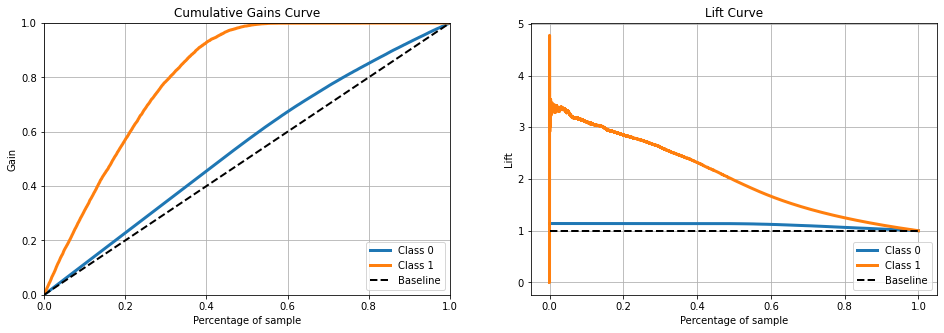

In [214]:
# model definition
xgb_model = xgb.XGBClassifier(n_estimators = 100)

# model fit
xgb_model.fit(x_train,y_train)

# model predict
yhat_xgb = xgb_model.predict_proba(x_val)

# plot
fig, ax = plt.subplots(1,2,figsize=(16,5))

# Accumulative Gain 
skplt.metrics.plot_cumulative_gain(y_validation,yhat_xgb,ax=ax[0])
skplt.metrics.plot_lift_curve(y_validation,yhat_xgb,ax=ax[1]);

### Cross Validation

In [215]:
xgb_cross = cross_validation(data_train,5,'XGBoost',xgb_model,verbose=False)
xgb_cross

,Model,Precision at K,Recall at K
0,XGBoost,0.35 +/- 0.0023,0.5706 +/- 0.0055


# 8.0 Model Performance

In [231]:
pd.concat([knn_cross, lr_cross, et_cross, xgb_cross])

,Model,Precision at K,Recall at K
0,KNN,0.3116 +/- 0.0034,0.508 +/- 0.0028
0,Logistic Regression,0.3305 +/- 0.0046,0.5388 +/- 0.0072
0,Extra Trees,0.3264 +/- 0.0022,0.5322 +/- 0.0018
0,XGBoost,0.35 +/- 0.0023,0.5706 +/- 0.0055


In [217]:
df8 = x_validation.copy()
df8['response'] = y_validation.copy()

# Propensity score
df8['score'] = yhat_lr[:,1].tolist()

# sort clients by propensity score
df8 = df8.sort_values('score',ascending=False)

# # Ranking
# df8['ranking'] = df8.reset_index().index

# compute precision at k
print('Precision at K: {}'.format(precision_at_k(df8,k=int(round(df8.shape[0]*0.2,0)))))
print('Recall at K: {}'.format(recall_at_k(df8,k=int(round(df8.shape[0]*0.2,0)))))

Precision at K: 0.28861921941620206
Recall at K: 0.4726608658287679


In [206]:
df8.head(30)

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_damage,previously_insured,annual_premium,vintage,vehicle_age_bellow_1_year,vehicle_age_between_1_2_year,vehicle_age_over_2_years,response,score,ranking
196517,45314,0.104208,0.169231,0.187540,0.000131,1,0.237608,0,0.454546,0.446367,1,0,0,0,0.904545,0
76998,232888,0.138361,0.523077,0.187540,0.208412,1,0.237608,0,5.886898,0.795848,0,1,0,0,0.829705,1
370806,298488,0.104208,0.476923,0.187540,0.208412,1,0.237608,0,6.095721,0.930796,0,0,1,1,0.782016,2
355073,173450,0.104208,0.261538,0.073871,0.194065,1,0.237608,0,5.550849,0.432526,0,1,0,0,0.720731,3
245469,56120,0.104208,0.415385,0.187540,0.000115,1,0.237608,0,1.746694,0.788927,0,1,0,1,0.713943,4
308549,179140,0.138361,0.384615,0.187540,0.208412,1,0.237608,0,3.130790,0.439446,0,1,0,0,0.678376,5
291365,41343,0.104208,0.215385,0.070677,0.194065,1,0.237608,0,-0.352468,0.076125,0,1,0,1,0.674407,6
201259,82689,0.138361,0.276923,0.187540,0.208412,1,0.237608,0,5.431951,0.467128,0,1,0,1,0.670947,7
76140,226172,0.138361,0.415385,0.080641,0.208412,1,0.237608,0,1.532319,0.743945,0,1,0,0,0.662953,8
116622,168721,0.104208,0.246154,0.111747,0.003290,1,0.237608,0,-0.672324,0.975779,0,1,0,1,0.655730,9


# Cross Validation

In [207]:

cross_validation(data_train,5,'XGBoost',xgb_model,verbose=True)

k_fold: 0
Validation Size: 60977 | 0 - 60977
Training Size: 243910
Total Size: 304887
Total Original Size: 304887
Precision at K: 0.34650705149229255
Recall at K:    0.5615200637788998





KeyboardInterrupt



In [ ]:
a

In [ ]:
b

In [ ]:
pd.DataFrame(
{'Model': model_name,
 'Precision at K': round(np.mean(a),4).astype(str) + ' +/- ' + round((np.std(a)),4).astype(str),
 'Recall at K':    round(np.mean(b),4).astype(str) + ' +/- ' + round((np.std(b)),4).astype(str)},index=[0])

In [ ]:
pd.DataFrame(
        {'Model Name': model_name,
         'MAE CV': np.round(np.mean(mae_list),2).astype(str) + ' +/- ' + np.round(np.std(mae_list),2).astype(str),
         'MAPE CV': np.round(np.mean(mape_list),2).astype(str) + ' +/- ' + np.round(np.std(mape_list),2).astype(str),
         'RMSE CV': np.round(np.mean(rmse_list),2).astype(str) + ' +/- ' + np.round(np.std(rmse_list),2).astype(str)},index=[0])